## C02.01.F5. Evaluate Model. Data Smoothed. All Features

# Script for evaluate a model trained.

The same process of transformation of the test data is followed as was done for the training data for the correct functioning of the model prediction. The results will reflect the true effectiveness of the trained model.

In [6]:
# Import libraries 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, cross_val_score
import lightgbm as ltb
import matplotlib.pyplot as plt 
import joblib
import time 
import warnings
warnings.filterwarnings("ignore")
import sys
t1 = time.time()

    From an fitted model makes a prediction and returns the results.
    
    Parameters:
        model: Model object fitted.
        X: Data with the independent variables to predict
        y: Data with the dependient variable to compare with the prediction
        thresholds: List of thresholds where to check for each of them, the 
        number of records of X below them.
        verbose: Defines whether or not the output is displayed.
    
    Returns:
        results: Pandas Dataframe with the results of the predictions:
            - REAL: Real value of dependent variable.
            - PRED: Prediction value of dependent variable.
            - PERCENTAGE_ERROR:  Percentage deviation mean error by row from REAL and PRED.
            - ABSOLUTE_ERROR: Absolute mean error by row from REAL and PRED.
            - R2_SCORE: R square score from REAL and PRED.

In [7]:
def eval_model(model, X, y, thresholds=[5], verbose=1):
    y_pred = model.predict(X)
    y = np.power(y,3)
    y_pred = np.power(y_pred,3)
    porc_error = abs(y_pred - y)*100/y
    absolute_mean_error = mean_absolute_error(y, y_pred)
    porcentual_mean_error = np.mean(porc_error[porc_error != np.inf])
    if verbose:
        print("\nTEST: Absolute Error:", absolute_mean_error)
        print("Porcentual Error:", porcentual_mean_error)
        print("STD Error:", np.std(abs(y - y_pred)))
        print("R2 Score:", r2_score(y, y_pred)) #Coef determ
    results = pd.DataFrame(np.array(y), columns = ['REAL'])
    results['PRED'] = y_pred
    results['PERCENTAGE_ERROR'] = np.abs(results['PRED'] - results['REAL'])*100/results['REAL'] 
    results['ABSOLUTE_ERROR'] = np.abs(results['PRED'] - results['REAL'])*100
    results['R2_SCORE'] = r2_score(results['REAL'], results['PRED'])
    
    for threshold in thresholds:
        hits = 0
        for element in results['ABSOLUTE_ERROR']:
            if element <= threshold:
                hits+=1
        
        porcentual_hits = hits*100/len(results)
        if verbose:
            print(str(porcentual_hits)+str("% registers are with less than"), str(threshold)+str("% of absolute error."))
            results['% REG ERROR < '+str(threshold)] = porcentual_hits
        
    return results

In [8]:
# Define INPUT and OUTPUT files

INPUT = '../../F3.Data Preparation/02_Data/sampled_test.csv'
#INPUT_FEATS = '../../F4.Modeling/02_Data/AllFeat_features.npy'
INPUT_MODEL = '../../F4.Modeling/02_Data/AllFeat_model.pkl'
INPUT_SC = '../../F4.Modeling/02_Data/AllFeat_sc_X.bin'
OUTPUT = '../02_Data/AllFeat_results_test.csv'
OUTPUT_TEST_RES = '../02_Data/AllFeat_test_results.csv'


In [10]:
# Read data resetting the indexes
data = pd.read_csv(INPUT, sep='|').reset_index(drop=True)

In [20]:
# Indexing the independent and dependent variables for test data in X and y respectively

to_delete = ['CUSTOMER_ID','BRANDFAMILY_ID','R', 'CAL_DATE', 'CAL_DATE_end','SO_ITG_WSE', 'SO_MRKT_WSE','QUOTA_SELLOUT']
X_test = data.drop(to_delete, axis=1)
y_test = data['QUOTA_SELLOUT']

In [21]:
# Load StandardScaler used in the traning phase and transform the test data
sc_X = joblib.load(INPUT_SC)
X_test = sc_X.transform(X_test)

In [22]:
# Same Gaussian transformation as the one used in training for dependent variable
y_test = y_test**(float(1)/3)

## Model Evaluation: Data Smoothed and All Features

In [23]:
## Model Evaluation: Data Smoothed and Feature Selection# Load trained model and evaluate with the test data
model = joblib.load(INPUT_MODEL)
res_test = eval_model(model, X_test, y_test, [1, 2, 5, 10])


TEST: Absolute Error: 0.01430686620365356
Porcentual Error: 44.6673988735318
STD Error: 0.022798761808710998
R2 Score: 0.9098250581819765
60.76374156219865% registers are with less than 1% of absolute error.
79.03370834672667% registers are with less than 2% of absolute error.
94.4723454409086% registers are with less than 5% of absolute error.
98.88696024858031% registers are with less than 10% of absolute error.


##### Best result with an R2 of 91%.

In [24]:
# Format results dataframe for write to file
res_test = data[['CUSTOMER_ID','BRANDFAMILY_ID','CAL_DATE','CAL_DATE_end']].reset_index(drop=True).merge(res_test, left_index=True, right_index=True)

In [25]:
# The data is written to a file
res_test.to_csv(OUTPUT_TEST_RES, sep='|', index=False)

In [26]:
t2 = time.time()
print ("Time to execute script:",str(round((t2-t1)/3600,2)), "h")

Time to execute script: 0.18 h


## Feature impact on prediction

In [27]:
## Feature impact on predictionimport seaborn as sns
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()   
    plt.show()

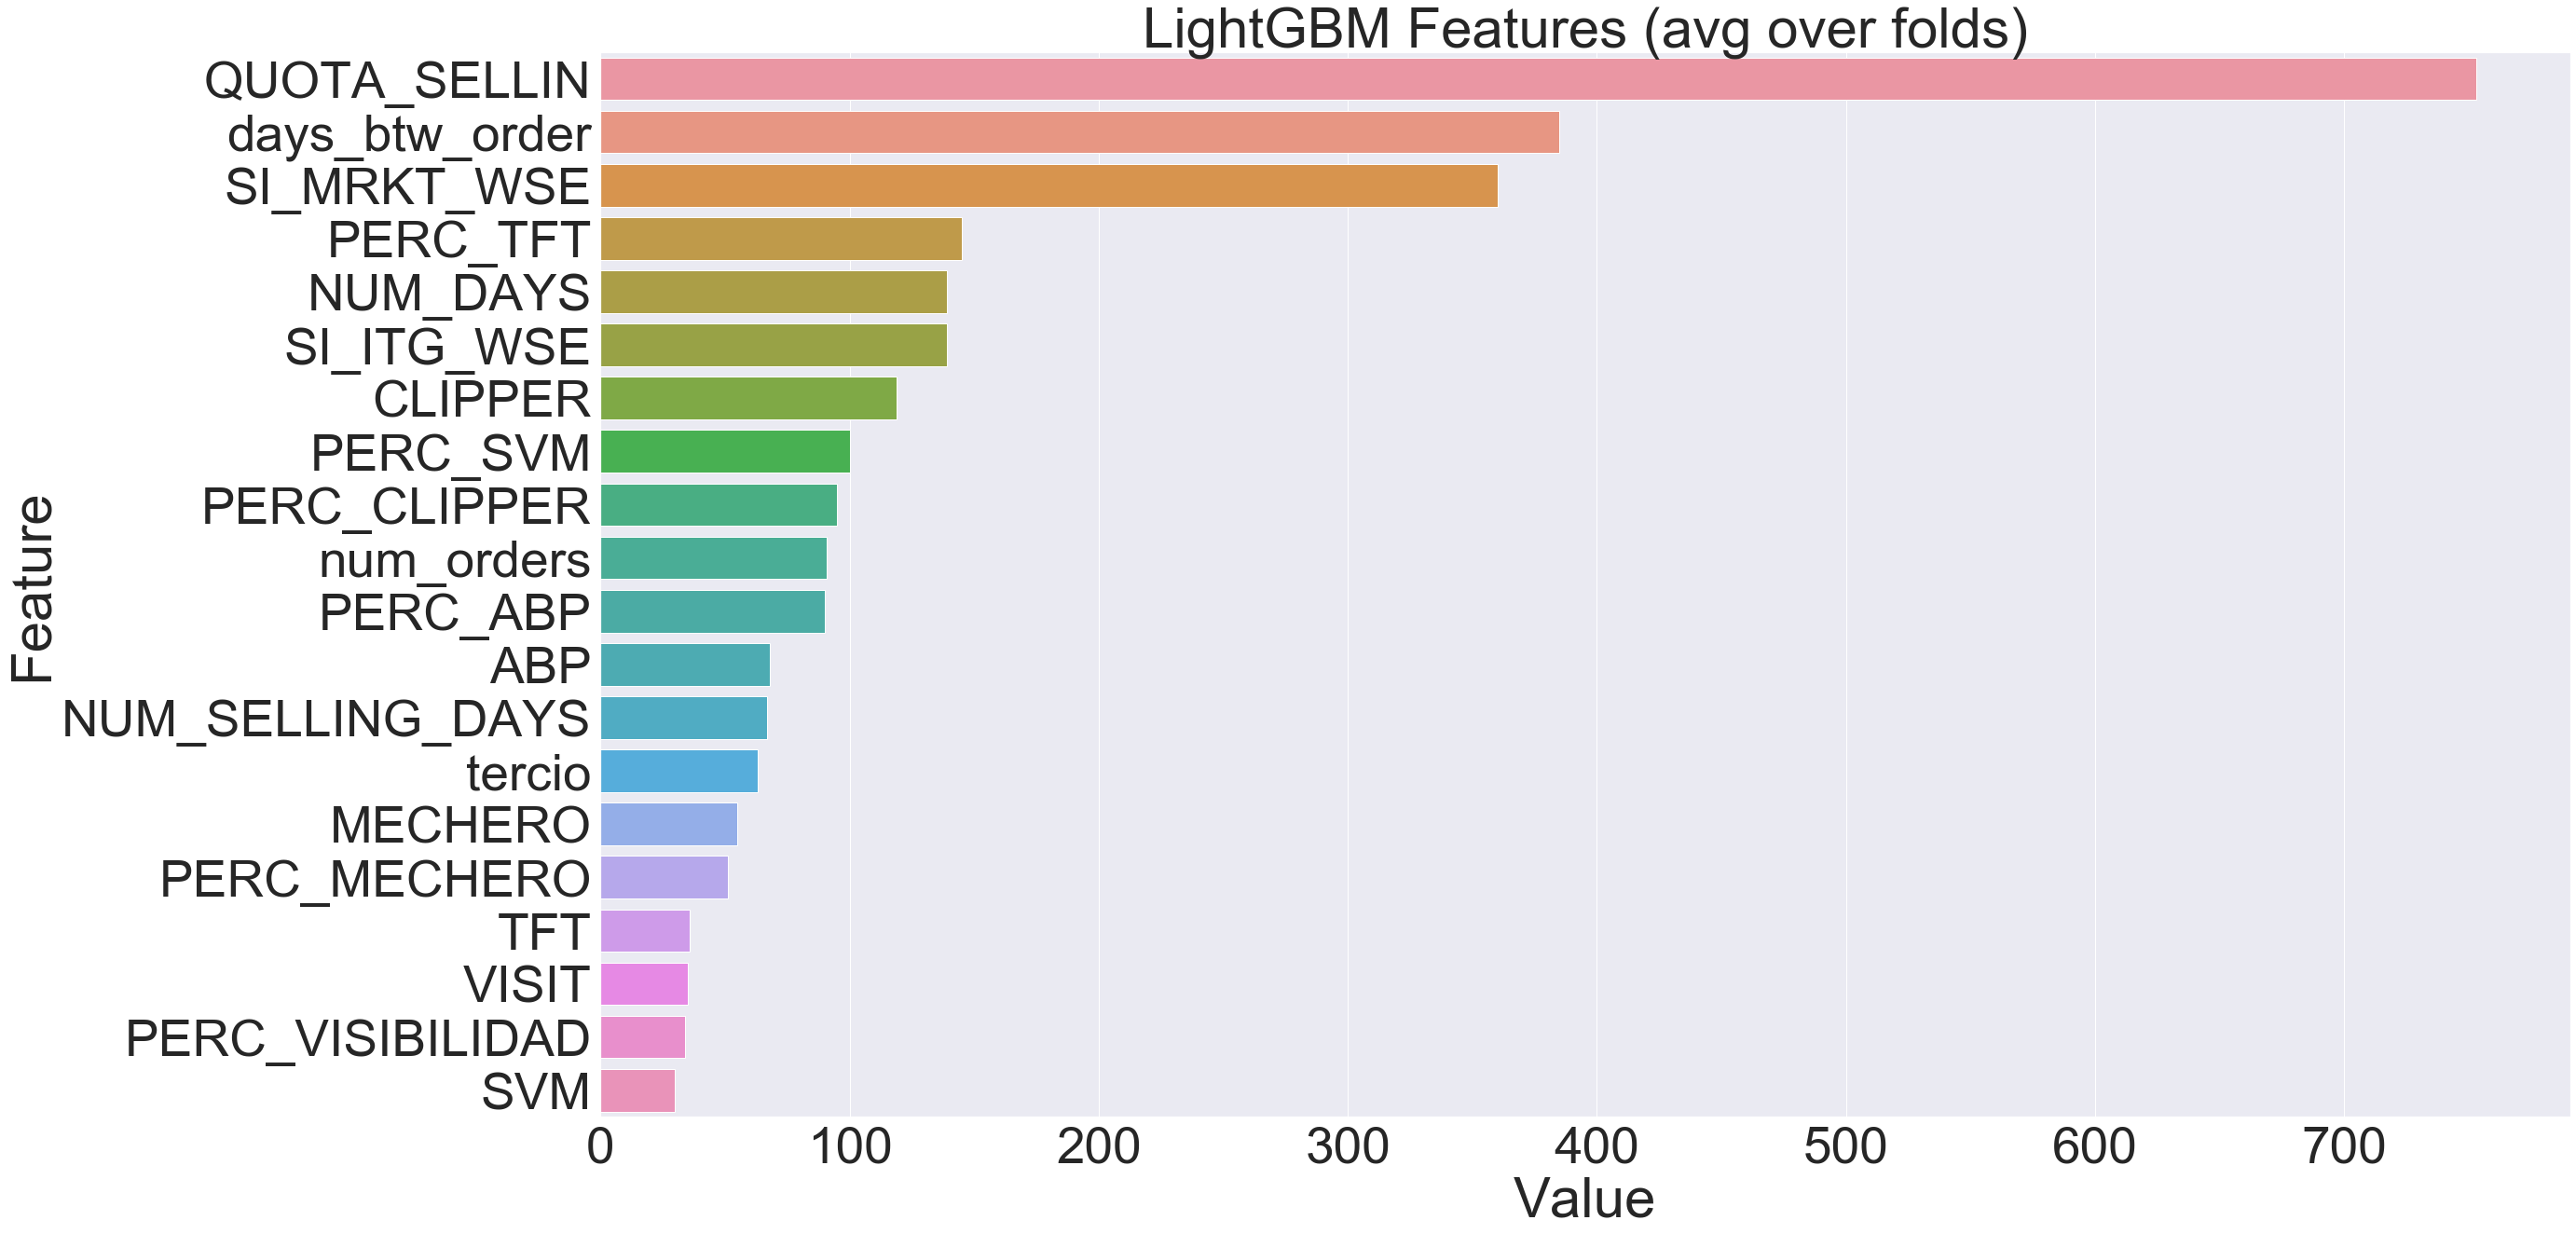

In [30]:
feats_to_explore=['tercio', 'NUM_SELLING_DAYS', 'NUM_DAYS', 'days_btw_order', 'num_orders', 'SI_ITG_WSE', 'SI_MRKT_WSE','QUOTA_SELLIN', 'MECHERO', 'CLIPPER', 'ABP', 'DISPENSADOR', 'VISIBILIDAD', 'AZAFATA', 'TOTEM', 'SVM', 'TFT', 'CUE', 'VISIT', 'PERC_MECHERO', 'PERC_CLIPPER', 'PERC_ABP', 'PERC_DISPENSADOR', 'PERC_VISIBILIDAD', 'PERC_AZAFATA', 'PERC_TOTEM', 'PERC_SVM', 'PERC_TFT', 'PERC_CUE', 'PERC_visit']
plotImp(model, feats_to_explore , num = 20, fig_size = (40, 20))

#### Quota Sell In has a significant impact on prediction. But the activities also contribute a significant amount.